<a href="https://colab.research.google.com/github/ShaliniR8/google-colab-notebooks/blob/master/voice_emotion_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
download = drive.CreateFile({'id': '1qcEwOgggrg-uP7KN1qZt9ZHhxrQnzlUY'})
download.GetContentFile('DOWNLOAD.tar')

In [19]:
import tarfile
if not os.path.isdir('dataset'):
  os.mkdir('dataset/')
  my_tar = tarfile.open('DOWNLOAD.tar')
  my_tar.extractall('./dataset') # specify which folder to extract to
  my_tar.close()

## Importing the required libraries

In [21]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [22]:
from keras import regularizers

In [23]:
path = 'dataset/AudioEmotion'
mylist= os.listdir(path)

In [26]:
type(mylist), len(mylist)

(list, 1440)

In [46]:
print(mylist[0])

03-01-07-02-02-01-20.wav


In [28]:
print(mylist[0][6:8])

07


## Plotting the audio file's waveform and its spectrogram

In [39]:
data, sampling_rate = librosa.load(path+ '/'+ mylist[1])
print(mylist[1])

03-01-04-02-01-01-24.wav


Populating the interactive namespace from numpy and matplotlib


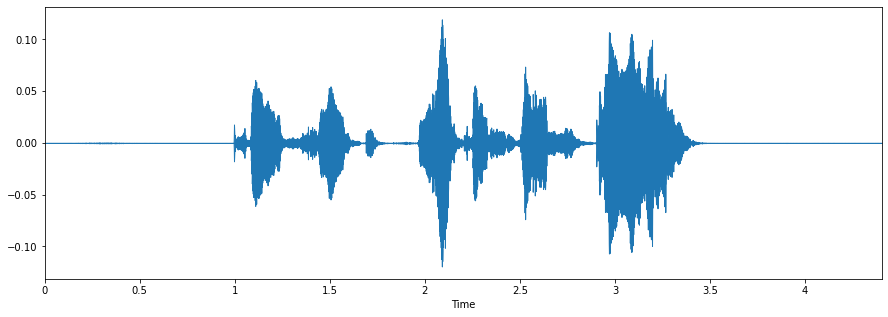

In [40]:
% pylab inline
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


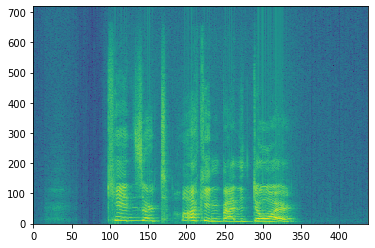

In [41]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read( path + '/' + mylist[1] )

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [48]:
feeling_list=[]
for item in mylist:
    if item[6:8]=='02' and int(item[-5:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:8]=='02' and int(item[-5:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:8]=='03' and int(item[-5:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:8]=='03' and int(item[-5:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:8]=='04' and int(item[-5:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:8]=='04' and int(item[-5:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:8]=='05' and int(item[-5:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:8]=='05' and int(item[-5:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:8]=='06' and int(item[-5:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:8]=='06' and int(item[-5:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[6:8]=='07' and int(item[-5:-4])%2==0:
        feeling_list.append('female_disgust')
    elif item[6:8]=='07' and int(item[-5:-4])%2==1:
        feeling_list.append('male_disgust')

In [49]:
labels = pd.DataFrame(feeling_list)

In [50]:
labels[:10]

,0
0,female_disgust
1,female_sad
2,male_fearful
3,male_calm
4,female_happy
5,male_disgust
6,male_disgust
7,male_fearful
8,female_happy
9,female_angry


## Getting the features of audio files using librosa

In [51]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:8]!='01' and mylist[index][6:8]!='08':
        X, sample_rate = librosa.load( path + '/' +y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [52]:
df[:5]

,feature
0,"[-57.79548555061434, -57.35450998621957, -56.9..."
1,"[-55.33527459031794, -55.29686360131606, -55.2..."
2,"[-53.37312542942387, -52.7433046744615, -53.67..."
3,"[-69.67328949566405, -69.69331084873151, -69.6..."
4,"[-40.58849697574595, -40.58108305270188, -40.6..."


In [53]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [54]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,-57.795486,-57.354510,-56.991731,-56.941869,-57.226564,-57.883706,-57.883706,-57.883706,-57.363471,-57.787919,-57.826575,-57.833826,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.859359,-56.492787,-56.072751,-57.201766,-57.143283,...,-47.814515,-47.138010,-46.109510,-44.590668,-41.035358,-40.457507,-41.275201,-41.924607,-42.187604,-41.821380,-40.781903,-42.755122,-43.804872,-42.430912,-42.737900,-40.200466,-42.215638,-42.684316,-42.840591,-45.332024,-43.294622,-42.121190,-42.127882,-42.752367,-42.939173,-42.552818,-42.564378,-41.440689,-40.913630,-41.384437,-43.569050,-44.218907,-44.728162,-45.129665,-46.271050,-47.300361,-48.031926,-49.856726,-50.489720,-44.885626
1,-55.335275,-55.296864,-55.296864,-55.322288,-55.296864,-55.296864,-55.335295,-55.320075,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,...,-39.535346,-40.488053,-41.084887,-40.676786,-38.563532,-37.730938,-40.503695,-44.791561,-43.508249,-42.166776,-40.601456,-39.915553,-41.363649,-43.126799,-45.089021,-43.151881,-41.116005,-39.998665,-39.601103,-39.220592,-41.315101,-42.688587,-42.517880,-44.129544,-44.716244,-44.695069,-45.925729,-45.632488,-44.205541,-42.839565,-37.798077,-32.190974,-32.079186,-37.891248,-40.393839,-40.878216,-41.835036,-43.871080,-41.851184,-40.520844
2,-53.373125,-52.743305,-53.675258,-51.377994,-48.809563,-49.030382,-50.372866,-53.675896,-54.552370,-53.142108,-53.610586,-55.433940,-57.951387,-54.885418,-51.634623,-50.901597,-49.966008,-50.504414,-52.608671,-51.308768,-48.925428,-49.034593,-50.118049,-48.654762,-47.483778,-49.641545,-50.835456,-50.754202,-50.612879,-49.287514,-49.468941,-50.591536,-49.770078,-51.247858,-51.414254,-49.884619,-51.044693,-50.304900,-47.951085,-47.445263,...,-34.308062,-35.459623,-32.315050,-29.291569,-28.605242,-30.595629,-30.725341,-29.119151,-29.952035,-32.545674,-31.675500,-30.063373,-31.051413,-34.074874,-32.301860,-31.661670,-32.654722,-35.001554,-33.362010,-33.474114,-36.106173,-37.089322,-37.812294,-37.449476,-36.287519,-37.229506,-39.164082,-40.187381,-40.446094,-41.107143,-39.674765,-39.598808,-40.024078,-40.442644,-41.814178,-44.120571,-45.215545,-43.757561,-43.507504,-44.861471
3,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-36.346081,-36.887523,-38.092933,-41.887760,-42.226526,-41.760117,-43.074402,-44.879066,-42.909646,-44.603615,-46.808209,-49.012126,-51.152079,-50.783257,-51.654354,-51.196208,-51.383033,-53.925649,-52.001230,-54.380229,-53.831395,-55.732981,-58.328104,-58.133457,-60.638192,-60.202337,-60.904657,-56.991737,-58.609988,-60.878177,-61.967161,-61.018557,-60.341144,-63.465331,-64.500144,-61.646850,-58.001485,-58.848490,-62.603930,-61.121783
4,-40.588497,-40.581083,-40.605576,-40.649172,-40.645645,-40.654913,-40.655991,-40.645635,-40.632103,-40.652580,-40.652711,-40.656857,-40.656176,-40.669192,-40.646030,-40.656857,-40

In [55]:
newdf = pd.concat([df3,labels], axis=1)

In [56]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [57]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
0,-57.795486,-57.354510,-56.991731,-56.941869,-57.226564,-57.883706,-57.883706,-57.883706,-57.363471,-57.787919,-57.826575,-57.833826,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.883706,-57.859359,-56.492787,-56.072751,-57.201766,-57.143283,...,-47.138010,-46.109510,-44.590668,-41.035358,-40.457507,-41.275201,-41.924607,-42.187604,-41.821380,-40.781903,-42.755122,-43.804872,-42.430912,-42.737900,-40.200466,-42.215638,-42.684316,-42.840591,-45.332024,-43.294622,-42.121190,-42.127882,-42.752367,-42.939173,-42.552818,-42.564378,-41.440689,-40.913630,-41.384437,-43.569050,-44.218907,-44.728162,-45.129665,-46.271050,-47.300361,-48.031926,-49.856726,-50.489720,-44.885626,female_disgust
1,-55.335275,-55.296864,-55.296864,-55.322288,-55.296864,-55.296864,-55.335295,-55.320075,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,-55.296864,...,-40.488053,-41.084887,-40.676786,-38.563532,-37.730938,-40.503695,-44.791561,-43.508249,-42.166776,-40.601456,-39.915553,-41.363649,-43.126799,-45.089021,-43.151881,-41.116005,-39.998665,-39.601103,-39.220592,-41.315101,-42.688587,-42.517880,-44.129544,-44.716244,-44.695069,-45.925729,-45.632488,-44.205541,-42.839565,-37.798077,-32.190974,-32.079186,-37.891248,-40.393839,-40.878216,-41.835036,-43.871080,-41.851184,-40.520844,female_sad
2,-53.373125,-52.743305,-53.675258,-51.377994,-48.809563,-49.030382,-50.372866,-53.675896,-54.552370,-53.142108,-53.610586,-55.433940,-57.951387,-54.885418,-51.634623,-50.901597,-49.966008,-50.504414,-52.608671,-51.308768,-48.925428,-49.034593,-50.118049,-48.654762,-47.483778,-49.641545,-50.835456,-50.754202,-50.612879,-49.287514,-49.468941,-50.591536,-49.770078,-51.247858,-51.414254,-49.884619,-51.044693,-50.304900,-47.951085,-47.445263,...,-35.459623,-32.315050,-29.291569,-28.605242,-30.595629,-30.725341,-29.119151,-29.952035,-32.545674,-31.675500,-30.063373,-31.051413,-34.074874,-32.301860,-31.661670,-32.654722,-35.001554,-33.362010,-33.474114,-36.106173,-37.089322,-37.812294,-37.449476,-36.287519,-37.229506,-39.164082,-40.187381,-40.446094,-41.107143,-39.674765,-39.598808,-40.024078,-40.442644,-41.814178,-44.120571,-45.215545,-43.757561,-43.507504,-44.861471,male_fearful
3,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,-67.251427,-69.333558,-69.693311,-69.693311,-69.647573,-69.679308,-69.693311,-69.588926,-69.181253,-66.818492,-65.784794,-69.063563,-69.693311,-64.038489,-58.784480,-59.416517,-66.427642,-69.693311,-67.027641,-62.696477,-58.779407,-59.776407,-59.815429,-63.297572,-63.207493,-60.560481,-60.138096,-59.228013,-55.839270,-55.880688,...,-36.887523,-38.092933,-41.887760,-42.226526,-41.760117,-43.074402,-44.879066,-42.909646,-44.603615,-46.808209,-49.012126,-51.152079,-50.783257,-51.654354,-51.196208,-51.383033,-53.925649,-52.001230,-54.380229,-53.831395,-55.732981,-58.328104,-58.133457,-60.638192,-60.202337,-60.904657,-56.991737,-58.609988,-60.878177,-61.967161,-61.018557,-60.341144,-63.465331,-64.500144,-61.646850,-58.001485,-58.848490,-62.603930,-61.121783,male_calm
4,-40.588497,-40.581083,-40.605576,-40.649172,-40.645645,-40.654913,-40.655991,-40.645635,-40.632103,-40.652580,-40.652711,-40.656857,-40.656176,-40.669192,-40.646030,-40.656857,

In [58]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,0
307,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.113893,-68.112516,-66.512500,-66.111032,-67.327924,-68.000343,-67.425239,-65.457427,-64.945733,-66.142684,-66.821275,...,-32.892080,-35.207829,-34.712072,-36.251649,-37.563867,-38.843320,-37.959478,-40.038168,-43.992956,-43.841568,-45.202527,-49.856324,-50.802413,-53.493723,-52.828835,-52.684123,-55.099530,-58.764610,-58.217360,-58.923805,-59.737026,-62.893766,-60.936932,-61.709319,-63.025318,-57.667865,-54.876664,-56.908098,-60.117090,-60.506290,-58.849657,-62.021500,-64.937743,-61.506925,-60.038988,-60.357319,-58.339954,-54.958505,-56.110400,male_disgust
848,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-43.013786,-42.384599,-40.989137,-39.368891,-38.886584,-38.502483,-37.448795,-35.389014,-35.558128,-33.843488,-33.831664,-34.632823,-33.573914,-31.910652,-31.458560,-31.484569,-30.655975,-28.481450,-27.559520,-30.064226,-31.060712,...,-33.894622,-31.893778,-30.865028,-30.923079,-32.499802,-32.767496,-28.866621,-28.339923,-31.522088,-33.376802,-34.718339,-34.714553,-34.403697,-33.660931,-34.043857,-32.723833,-31.602427,-33.295151,-33.591077,-32.183979,-33.024024,-31.961688,-31.091820,-32.304423,-30.359448,-29.024328,-30.510311,-31.038963,-31.819321,-30.548160,-29.464094,-28.035271,-26.927565,-28.122175,-30.396886,-29.854355,-27.671695,-26.385856,-24.183284,female_fearful
529,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.721584,-65.819291,-66.165429,...,-66.442684,-66.489913,-66.304512,-66.573799,-66.744720,-66.868760,-66.283152,-66.308846,-65.391686,-64.757309,-65.218572,-66.486624,-66.166373,-66.730016,-66.719237,-66.657155,-65.778694,-65.456764,-65.775622,-66.007032,-64.799154,-63.387853,-65.260329,-66.263540,-65.213502,-65.815507,-66.185095,-66.316683,-66.730016,-66.730016,-66.730016,-66.730016,-66.659748,-66.092053,-66.427894,-66.730016,-66.561697,-65.296328,-65.721545,female_angry
989,-52.988201,-53.102028,-53.116916,-53.790555,-54.014885,-54.485966,-54.411586,-54.115248,-52.942502,-52.026787,-52.549309,-53.309186,-53.145254,-51.814773,-51.866667,-52.202169,-51.856568,-52.009184,-51.704403,-51.743289,-51.714802,-52.141066,-52.194026,-51.424969,-51.559307,-51.833913,-53.441757,-53.548466,-53.391825,-54.042188,-53.879145,-53.792032,-53.112843,-54.485732,-54.111956,-54.183267,-54.240385,-54.240385,-54.240385,-54.240385,...,-34.748628,-38.335943,-39.572430,-39.748540,-39.747085,-40.317639,-40.367350,-40.739620,-41.829078,-42.797479,-43.804620,-44.688263,-43.426044,-43.882901,-43.873496,-45.365695,-47.618834,-47.753597,-46.239088,-46.883662,-48.668606,-51.563355,-50.982342,-49.624893,-51.010500,-51.841084,-52.496111,-53.298488,-53.552220,-52.816773,-53.352215,-54.098376,-53.875476,-54.247334,-54.239586,-53.348464,-53.820837,-54.235142,-54.240385,male_fearful
747,-39.097205,-38.488296,-37.440983,-37.764197,-36.837550,-36.836799,-36.750015,-37.506800,-38.380182,-38.947473,-38.035465,-38.429130,-38.425958,-36.617261,-35.857

In [59]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [60]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [ ]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1565,-25.501792,-26.071097,-28.139215,-28.083108,-29.027153,-29.084228,-29.444832,-28.174279,-26.825199,-25.776648,...,-28.675121,-28.234779,-28.040587,-28.183097,-27.638088,-28.436068,-29.349459,-31.348238,-32.599974,male_sad
352,-42.612174,-44.166237,-46.185036,-44.702588,-42.975322,-44.313460,-44.428072,-44.274411,-43.780628,-43.182182,...,-39.133879,-39.412003,-37.711996,-39.044554,-38.289962,-38.845617,-40.895972,-42.263709,-41.276468,male_happy
337,-53.381730,-53.180815,-52.933302,-53.063797,-53.269084,-52.884994,-53.325040,-52.097120,-50.897439,-51.841784,...,-53.181291,-53.471820,-53.331062,-53.277394,-53.471820,-53.471820,-53.471820,-53.471820,-53.471820,female_happy
1557,-31.908893,-29.785277,-29.312566,-29.340708,-29.309514,-31.234801,-31.892522,-29.230806,-26.412683,-25.962694,...,-28.468336,-29.646353,-28.075079,-28.881573,-28.615487,-28.692476,-28.945379,-26.115368,-24.266730,male_sad
142,-67.997873,-67.997873,-67.997873,-67.997873,-67.901045,-65.704135,-66.570574,-67.737900,-67.997873,-67.997873,...,-25.700011,-24.859504,-23.396612,-21.860789,-22.140767,-21.855355,-23.117520,-21.937875,-19.853739,male_calm
1611,-28.023489,-27.012539,-24.843077,-26.073845,-26.605960,-25.415706,-26.137463,-25.882579,-26.144014,-25.486000,...,-9.060266,-10.795528,-11.224794,-10.564187,-10.653920,-10.423875,-10.612708,-9.730200,-6.192753,male_sad
1312,6.513997,2.688604,-14.524403,-16.414605,-16.501808,-15.895883,-18.425453,-18.493186,-19.697174,-20.406525,...,-18.862519,-20.383509,-19.070432,-18.314215,-18.376352,-18.308258,-15.165213,-6.792507,-0.884134,male_fearful
174,-67.851589,-68.222956,-71.009622,-71.753631,-68.483130,-66.897252,-68.951866,-71.381363,-74.111062,-75.449917,...,-29.047171,-28.798121,-29.476985,-29.069542,-29.336515,-29.969129,-30.079989,-26.872842,-23.062258,male_calm
1561,-26.477874,-21.849877,-11.200553,-6.713980,-5.940031,-6.923090,-7.600638,-7.370041,-7.653199,-9.667168,...,-7.755277,-6.800155,-6.931997,-8.070164,-6.287150,-5.732645,-5.968971,-2.897270,-0.117555,male_sad
224,-57.338221,-59.334333,-59.049307,-60.715965,-62.138004,-60.609590,-60.180352,-60.997297,-61.306802,-61.226960,...,-52.162158,-52.850261,-52.955079,-52.390493,-48.519363,-46.721866,-48.350662,-53.439951,-51.079765,male_happy


In [61]:
trainfeatures = train.iloc[:, :-1]

In [62]:
trainlabel = train.iloc[:, -1:]

In [63]:
testfeatures = test.iloc[:, :-1]

In [64]:
testlabel = test.iloc[:, -1:]

In [65]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [66]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [67]:
X_train.shape

(921, 216)

## Padding sequence for CNN model

In [68]:
print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [74]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(12))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [75]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 216, 128)          768       
_________________________________________________________________
activation_14 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 216, 128)          82048     
_________________________________________________________________
activation_15 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 27, 128)          

In [76]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [77]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=1009, validation_data=(x_testcnn, y_test))

Epoch 1/1009
29/29 [==============================] - 4s 152ms/step - loss: 2.6867 - accuracy: 0.0782 - val_loss: 2.5226 - val_accuracy: 0.0779
Epoch 2/1009
29/29 [==============================] - 4s 150ms/step - loss: 2.5580 - accuracy: 0.0749 - val_loss: 2.4939 - val_accuracy: 0.0952
Epoch 3/1009
29/29 [==============================] - 4s 144ms/step - loss: 2.5207 - accuracy: 0.1107 - val_loss: 2.4750 - val_accuracy: 0.1169
Epoch 4/1009
29/29 [==============================] - 4s 145ms/step - loss: 2.4986 - accuracy: 0.0999 - val_loss: 2.4597 - val_accuracy: 0.1082
Epoch 5/1009
29/29 [==============================] - 4s 146ms/step - loss: 2.4764 - accuracy: 0.1086 - val_loss: 2.4474 - val_accuracy: 0.1039
Epoch 6/1009
29/29 [==============================] - 4s 144ms/step - loss: 2.4624 - accuracy: 0.1086 - val_loss: 2.4389 - val_accuracy: 0.0909
Epoch 7/1009
29/29 [==============================] - 4s 145ms/step - loss: 2.4592 - accuracy: 0.1086 - val_loss: 2.4250 - val_accuracy:

## Plotting the accuracy and loss graph

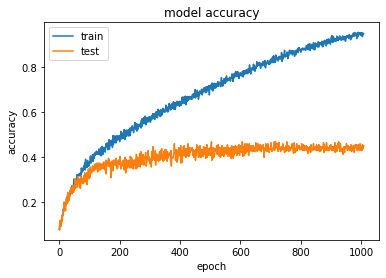

In [80]:
#sigmoid
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

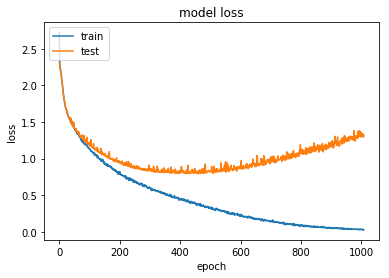

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [78]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


## Predicting emotions on the test data

In [ ]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [ ]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)